<a href="https://colab.research.google.com/github/c-walls/Essay-Score-Predictions/blob/main/LGBM_EssayConstructor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S R
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

DATA_SOURCE_MAPPING = 'linking-writing-processes-to-writing-quality:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F59291%2F6678907%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240328%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240328T011553Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2cf3263882945d2d403d09c82a02c03f75e99d9dc23517fa32d55d8642dd75b7c15904130575a0d5399c9362095593fc7ee2c632d990a65469101e939d2fd06467312b94a53ccad9541b6d6ebea4976033512121b716d0cde5d566cfb2d3feb0b8dc34494577e76263aaabe6a9cca3d23cb3b1f581f39311e1133a9773b7d4d520ba8af3bd590412f3de5ebb181a3ccf81f7874ed4cbefe5989e3071eeb7841aeeb1a90e480de9bfce9f45553b5c0655051d61c7bde4ade586f5e3633a034d923af63efc8d1b274462fc32db1ed3bf15e477b05c77dac5f3cc1177b1a6aacc96330b31e77bcb4bff862632abd56213e040dc306e9f4a44a03f713bac6afbfd72'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'

system(paste0('sudo umount ', '/kaggle/input'))
system(paste0('sudo rmdir ', '/kaggle/input'))
system(paste0('sudo mkdir -p -- ', KAGGLE_INPUT_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_INPUT_PATH), intern=TRUE)
system(paste0('sudo ln -sfn ', KAGGLE_INPUT_PATH,' ',file.path('..', 'input')), intern=TRUE)
system(paste0('sudo mkdir -p -- ', KAGGLE_WORKING_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_WORKING_PATH), intern=TRUE)
system(paste0('sudo ln -sfn ', KAGGLE_WORKING_PATH, ' ', file.path('..', 'working')), intern=TRUE)

data_source_mappings = strsplit(DATA_SOURCE_MAPPING, ',')[[1]]
for (data_source_mapping in data_source_mappings) {
    path_and_url = strsplit(data_source_mapping, ':')
    directory = path_and_url[[1]][1]
    download_url = URLdecode(path_and_url[[1]][2])
    filename = sub("\\?.+", "", download_url)
    destination_path = file.path(KAGGLE_INPUT_PATH, directory)
    print(paste0('Downloading and uncompressing: ', directory))
    if (endsWith(filename, '.zip')){
      temp = tempfile(fileext = '.zip')
      download.file(download_url, temp)
      unzip(temp, overwrite = TRUE, exdir = destination_path)
      unlink(temp)
    }
    else{
      temp = tempfile(fileext = '.tar')
      download.file(download_url, temp)
      untar(temp, exdir = destination_path)
      unlink(temp)
    }
    print(paste0('Downloaded and uncompressed: ', directory))
}

print(paste0('Data source import complete'))

character(0)

character(0)

character(0)

character(0)

character(0)

character(0)

[1] "Downloading and uncompressing: linking-writing-processes-to-writing-quality"
[1] "Downloaded and uncompressed: linking-writing-processes-to-writing-quality"
[1] "Data source import complete"


In [5]:
install.packages("moments")
install.packages("caTools")
install.packages("lightgbm")
install.packages("caret")

library(moments)
library(ggplot2)
library(caTools)
library(lightgbm)
library(readr)
library(caret)

train_scores <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv")
train_logs <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv")
sample_submission <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv")
test_logs <- read.csv("/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv")
test_scores <- data.frame(id = unique(test_logs$id))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: lattice



# DATA CLEANING

In [6]:
data_cleaning <-  function(logs) {

    #Simplify Move Activities
    tryCatch ({
        logs[substr(logs$activity, 1, 1) == "M", ]$text_change <- strsplit(logs[substr(logs$activity, 1, 1) == "M", ]$activity, " From ")[[1]][2]
        logs[substr(logs$activity, 1, 1) == "M", ]$activity <- "Move"
    }, error = function(e) {
        cat("Error reformatting MOVE activities:\n", conditionMessage(e), "\n")
    })

    #Convert Activity to Factor
    logs$activity <- as.factor(logs$activity)
    str(logs$activity)

    #Combine Event Columns
    logs <- logs[, names(logs) != "up_event"]
    names(logs)[names(logs) == "down_event"] <- "event"

    #Simplify Event Values
    logs$event <- gsub("(?i)(F[0-9]{1,2}|.*Media.*|.*Audio.*|.*Pause.*).*", "DeviceFeatureChangeKey", logs$event)
    logs$event <- gsub("(?i)(Scroll.*|Meta|Dead|Process|OS|AltGraph|Mode.*)", "SpecialProcessKey", logs$event)
    logs$event <- gsub("(?i)(Clear|Cancel)", "Escape", logs$event)
    logs$event <- gsub("^[0-9]$", "DigitKey", logs$event)
    logs$event <- gsub("(?i).*Arrow.*", "ArrowKey", logs$event)
    logs$event <- gsub("(?i)(Home|End|^Page.*)", "TextJumpKey", logs$event)

    #Compile list of allowed event values
    event_labels <- c("^[A-Za-z]$", "^[[:punct:]]$", "click", "Shift", "Space", "Backspace", "Enter", "Tab", "Caps", "Control", "Delete", "Insert", "Escape", "Print", "RareKey", "NumLock", "Alt", "ContextMenu", "ArrowKey", "TextJumpKey", "DeviceFeatureChangeKey", "SpecialProcessKey", "DigitKey", "Unidentified")
    valid_events <- unique(logs$event)[apply(sapply(event_labels, function(x) grepl(x, unique(logs$event))), 1, any)]

    #Replace remaining event values with "Unidentified"
    cat("\n", "\n", "INVALID VALUES: ")
    invalid_events <- setdiff(unique(logs$event), valid_events)
    print(table(invalid_events))
    logs$event[logs$event %in% invalid_events] <- "Unidentified"

    #Replace text_change values with "q" for essay constructor
    cat("\n", "\n", "INVALID TEXT_CHANGE VALUES: ")
    print(table(logs$text_change[logs$text_change %in% invalid_events]))
    logs$text_change[logs$text_change %in% invalid_events] <- "q"

    #Recording valid inputs for essay constructor
    text_change_inputs <- unique(logs[logs$activity == "Input", ]$event)
    text_change_inputs <- gsub("Space", " ", text_change_inputs)
    text_change_inputs <- gsub("Enter", "\n", text_change_inputs)
    text_change_inputs <- text_change_inputs[text_change_inputs != "Unidentified"]

    cat("\n", "RARE VALUES: ")
    print(names(which(table(logs$event) < 25)))
    logs$event[logs$event %in% names(which(table(logs$event) < 25))] <- "RareKey"

    cat("\n", "REMAINING VALUES: ")
    print(unique(logs$event))
    cat("Total 'Event' Values: ", length(unique(logs$event)))

    #Convert event variable to factor and check
    logs$event <- as.factor(logs$event)
    str(logs$event)


    #Fixing text_change errors for essay constructor
    cat("\n", "VALID TEXT_CHANGE VALUES: ")
    print(text_change_inputs)
    text_change_correction <- logs[logs$activity == "Replace" | logs$activity == "Paste", ]$text_change
    split_value <- c()

    if (length(text_change_correction) > 0) {

        for (i in 1:length(text_change_correction)) {
        split_value <- strsplit(text_change_correction[i], "")[[1]]

            if (length(split_value[!split_value %in% text_change_inputs]) > 0) {
                print(paste("Iteration: ", i))
                print(split_value[!split_value %in% text_change_inputs])
            }

        split_value[!split_value %in% text_change_inputs] <- "q"
        text_change_correction[i] <- paste(split_value, collapse = "")
        }
    }

    logs[logs$activity == "Replace" | logs$activity == "Paste", ]$text_change <- text_change_correction
    return(logs)
}

train_logs <- data_cleaning(train_logs)

 Factor w/ 6 levels "Input","Move",..: 3 3 3 1 1 1 1 1 1 1 ...

 
 INVALID VALUES: invalid_events
       \u0096        \u009b        \u0097        \u0080 â\u0080\u0093 
            1             1             1             1             1 
      Å\u009f             ä            Â´            Ä±       Ë\u0086 
            1             1             1             1             1 

 
 INVALID TEXT_CHANGE VALUES: 
       \u0096        \u009b        \u0097        \u0080 â\u0080\u0093 
            2             2            14             2             4 
      Å\u009f             ä            Â´            Ä±       Ë\u0086 
            2             2             2             6             2 

 RARE VALUES:  [1] "_"            "¡"            "¿"            "{"            "}"           
 [6] "@"            "#"            "`"            "^"            "|"           
[11] "~"            "A"            "b"            "C"            "d"           
[16] "e"            "f"            "F"        

# ESSAY CONSTRUCTOR

In [7]:
essay_constructor <- function(x) {
    operations <- x[, c("activity", "cursor_position", "event", "text_change")]
    essay <- character(0)
    expected_length <- 0
    error_messages <- character(0)

    # Capitalize Inputs from Shift Events
    for (i in 1:nrow(operations)) {
        if (operations$activity[i] == "Nonproduction" & operations$event[i] == "Shift" & i != nrow(operations)) {
            if (operations$activity[i + 1] == "Input" & operations$text_change[i + 1] == "q") {
                operations$text_change[i + 1] <- "Q"
            }
        }
    }

    # Initial Processing Loop
    for (i in 1:nrow(operations)) {
        starting_position <- 0
        input <- character(0)

        if (operations$activity[i] == "Remove/Cut") {

            expected_length <- expected_length - nchar(operations$text_change[i])
            essay <- essay[-((operations$cursor_position[i] + 1):(operations$cursor_position[i] + (nchar(operations$text_change[i]))))]

        } else if (operations$activity[i] == "Input") {

            input <- strsplit(operations$text_change[i], "")[[1]]
            starting_position <- operations$cursor_position[i] - length(input) + 1

        } else if (operations$activity[i] == "Paste") {

            input <- strsplit(operations$text_change[i], "")[[1]]
            starting_position <- operations$cursor_position[i] - length(input) + 1

        } else if (operations$activity[i] == "Move") {

            move_indexes <- strsplit(operations$text_change[i], " To ")[[1]]
            initial_location <- as.numeric(strsplit(substr(move_indexes[1], 2, nchar(move_indexes[1]) - 1), ", ")[[1]])
            new_location <- as.numeric(strsplit(substr(move_indexes[2], 2, nchar(move_indexes[2]) - 1), ", ")[[1]])

            if (initial_location[2] - initial_location[1] != new_location[2] - new_location[1]) {
                error_messages <- c(error_messages, paste("Move Error in Row ", i, ":  initial location range: ", initial_location[2] - initial_location[1], "  -  new location range: ", new_location[2] - new_location[1]))
            }

            input <- essay[(initial_location[1] + 1):(initial_location[2] + 1)]
            essay <- essay[-((initial_location[1] + 1):(initial_location[2] + 1))]
            expected_length <- expected_length - length(input)
            starting_position <- new_location[1] + 1

        } else if (operations$activity[i] == "Replace") {

            value <- strsplit(operations$text_change[i], " => ")[[1]]
            input <- strsplit(value[2], "")[[1]]
            starting_position <- operations$cursor_position[i] - length(input) + 1

            if ((starting_position + nchar(value[1]) - 1) > length(essay) + 1) {
                error_messages <- c(error_messages, paste("Error with 'Replace' starting_position: ", starting_position, "  End of value[1]: ", (starting_position + nchar(value[1]) - 1), "  Essay Length: ", length(essay)))
                starting_position <- length(essay) - nchar(value[1]) + 2

            } else if (starting_position <= 0) {
                c(error_messages, paste("Error with 'Replace' starting_position (before the essay)): ", starting_position))
                starting_position <- 1
            }

            essay <- essay[-((starting_position):(starting_position + (nchar(value[1]) - 1)))]
            expected_length <- expected_length - nchar(value[1])

        }

      # Input Processing Loop
        if (operations$activity[i] != "Remove/Cut" & operations$activity[i] != "Nonproduction") {
            if (starting_position == (length(essay) + 1)) {
                essay <- c(essay, input)
            } else if (starting_position == 1) {
                essay <- c(input, essay)
            } else if (starting_position > 1 & starting_position <= length(essay)) {
                essay <- c(essay[1:starting_position - 1], input, essay[(starting_position):length(essay)])
            } else if (starting_position > length(essay) + 1) {
                correction <- starting_position - (length(essay) + 1)
                error_messages <- c(error_messages, paste("Starting Position Past End of Essay in Row:", i, "  Starting Position: ", starting_position, "  Length of Essay: ", length(essay), "@'s added: ", correction))
                essay <- c(essay, input, strsplit(strrep("@", correction), "")[[1]])
                expected_length <- expected_length + correction
            } else if (starting_position < 1) {
                essay <- c(input, essay)
                error_messages <- c(error_messages, paste("Starting Position Error in Row:", i, "  Starting Position: ", starting_position, "  Length of Essay: ", length(essay)))
            }
            expected_length <- expected_length + length(input)
        }

        ifelse(expected_length != length(essay), error_messages <- c(error_messages, paste("Length Error in Row:", i, "  Expected Length: ", expected_length, " Actual Length: ", length(essay))), next)

    }

    return(list(essay, error_messages))
}

# Apply the essay constructor to each participant's logs
get_essay <- function(logs, scores) {
    essay_df <- data.frame(id = scores$id)
    essay_errors <- character(0)
    error_rate <- 0

    for (i in 1:nrow(essay_df)) {
        essay <- essay_constructor(logs[logs$id == scores$id[i],])
        na_amount <- sum(is.na(essay[[1]]))
        error_char_amount <- length(essay[[1]][essay[[1]] == "@"])
        essay_df$essay[i] <- paste(essay[[1]], collapse = "")

        if (length(essay[[2]]) > 0 | na_amount > 0 | error_char_amount > 0) {
            essay_errors <- c(essay_errors, paste("Submission #: ", i, "   Id: ", essay_df$id[i], "  NA Values: ", na_amount, "  @-Values: ", error_char_amount), essay[[2]])
            error_rate <- error_rate + 1
        }
    }

    print(paste("Total Number of Essays with Errors: ", error_rate))
    scores <- merge(essay_df, scores, by = "id")
    return(scores)

}

train_scores <- get_essay(train_logs, train_scores)

[1] "Total Number of Essays with Errors:  4"


# ESSAY CONSTRUCTOR FEATURES

In [8]:
create_essay_features <- function(scores) {
    scores$total_char <- nchar(scores$essay)
    scores$total_words <- sapply(strsplit(scores$essay, "\\s+"), length)
    scores$total_sentences <- sapply(strsplit(scores$essay, "[.!?]"), length)
    scores$total_paragraphs <- sapply(strsplit(scores$essay, "\\n+"), length)
    scores$avg_word_length <- scores$total_char / scores$total_words
    scores$avg_sentence_length <- scores$total_words / scores$total_sentences
    scores$avg_paragraph_length <- scores$total_sentences / scores$total_paragraphs
    scores$word_paragraph_ratio <- scores$total_words / scores$total_paragraphs
    scores$one_letter_word_ratio <- sapply(strsplit(scores$essay, "\\s+"), function(x) sum(nchar(x) == 1)) / scores$total_words
    scores$two_letter_word_ratio <- sapply(strsplit(scores$essay, "\\s+"), function(x) sum(nchar(x) == 2)) / scores$total_words
    scores$three_letter_word_ratio <- sapply(strsplit(scores$essay, "\\s+"), function(x) sum(nchar(x) == 3)) / scores$total_words
    scores$four_letter_word_ratio <- sapply(strsplit(scores$essay, "\\s+"), function(x) sum(nchar(x) == 4)) / scores$total_words
    scores$five_letter_word_ratio <- sapply(strsplit(scores$essay, "\\s+"), function(x) sum(nchar(x) == 5)) / scores$total_words
    scores$six_letter_word_ratio <- sapply(strsplit(scores$essay, "\\s+"), function(x) sum(nchar(x) == 6)) / scores$total_words
    scores$seven_letter_word_ratio <- sapply(strsplit(scores$essay, "\\s+"), function(x) sum(nchar(x) == 7)) / scores$total_words
    scores$eight_plus_word_ratio <- sapply(strsplit(scores$essay, "\\s+"), function(x) sum(nchar(x) > 7)) / scores$total_words
    scores$comma_count_2 <- sapply(strsplit(scores$essay, "\\s+"), function(x) sum(grepl(",", x)))
    scores$comma_ratio <- scores$comma_count / scores$total_words
    scores$comma_sentence_ratio <- scores$comma_count / scores$total_sentences
    scores$punctuation_count_2 <- sapply(strsplit(scores$essay, "\\s+"), function(x) sum(grepl("[[:punct:]]", x)))
    scores$punctuation_ratio <- scores$punctuation_count / scores$total_words
    scores$punctuation_sentence_ratio <- scores$punctuation_count / scores$total_sentences
    scores$clause_count <- sapply(strsplit(scores$essay, "[.!?,:;(){}[]]"), function(x) sum(grepl(",", x)))
    scores$clause_ratio <- scores$clause_count / scores$total_sentences
    scores$two_word_sentence_ratio <- sapply(strsplit(scores$essay, "[.!?]"), function(x) sum(sapply(strsplit(x, "\\s+"), length) == 2)) / scores$total_sentences
    scores$three_word_sentence_ratio <- sapply(strsplit(scores$essay, "[.!?]"), function(x) sum(sapply(strsplit(x, "\\s+"), length) == 3)) / scores$total_sentences
    scores$four_word_sentence_ratio <- sapply(strsplit(scores$essay, "[.!?]"), function(x) sum(sapply(strsplit(x, "\\s+"), length) == 4)) / scores$total_sentences
    scores$five_word_sentence_ratio <- sapply(strsplit(scores$essay, "[.!?]"), function(x) sum(sapply(strsplit(x, "\\s+"), length) == 5)) / scores$total_sentences
    scores$six_word_sentence_ratio <- sapply(strsplit(scores$essay, "[.!?]"), function(x) sum(sapply(strsplit(x, "\\s+"), length) == 6)) / scores$total_sentences
    scores$seven_word_sentence_ratio <- sapply(strsplit(scores$essay, "[.!?]"), function(x) sum(sapply(strsplit(x, "\\s+"), length) == 7)) / scores$total_sentences
    scores$eight_word_sentence_ratio <- sapply(strsplit(scores$essay, "[.!?]"), function(x) sum(sapply(strsplit(x, "\\s+"), length) == 8)) / scores$total_sentences
    scores$nine_word_sentence_ratio <- sapply(strsplit(scores$essay, "[.!?]"), function(x) sum(sapply(strsplit(x, "\\s+"), length) == 9)) / scores$total_sentences
    scores$ten_plus_word_sentence_ratio <- sapply(strsplit(scores$essay, "[.!?]"), function(x) sum(sapply(strsplit(x, "\\s+"), length) == 10)) / scores$total_sentences
    scores$unique_word_count <- sapply(strsplit(scores$essay, "\\s+"), function(x) length(unique(x)))
    return(scores)
}

train_scores <- create_essay_features(train_scores)
cor(train_scores[, sapply(train_scores, is.numeric)])
train_scores <- train_scores[, c(names(train_scores)[names(train_scores) != "score"], "score")]

,score,total_char,total_words,total_sentences,total_paragraphs,avg_word_length,avg_sentence_length,avg_paragraph_length,word_paragraph_ratio,one_letter_word_ratio,⋯,two_word_sentence_ratio,three_word_sentence_ratio,four_word_sentence_ratio,five_word_sentence_ratio,six_word_sentence_ratio,seven_word_sentence_ratio,eight_word_sentence_ratio,nine_word_sentence_ratio,ten_plus_word_sentence_ratio,unique_word_count
score,1.000000000,0.65804315,0.639422711,0.465029642,0.176266178,0.024455324,0.024317540,0.137811106,0.288545331,-8.223395e-03,⋯,0.024536182,0.036741499,-0.01987544,-0.01538779,-0.10096310,-0.173291299,-0.203532220,-0.187632952,-1.568912e-01,0.652860657
total_char,0.658043148,1.00000000,0.984877315,0.769235732,0.379724763,0.061087294,0.105651271,0.281921454,0.468300588,2.683838e-02,⋯,0.012893491,0.046305892,0.01570494,0.02395136,-0.05939502,-0.106980556,-0.131241864,-0.128495312,-1.187457e-01,0.730620190
total_words,0.639422711,0.98487731,1.000000000,0.788708753,0.356290332,-0.098634004,0.106706499,0.306631107,0.490161025,7.589503e-02,⋯,0.016220265,0.051832147,0.02278454,0.03175946,-0.04796408,-0.103011063,-0.133007279,-0.126855709,-1.283554e-01,0.716214247
total_sentences,0.465029642,0.76923573,0.788708753,1.000000000,0.382185931,-0.082409522,-0.352512941,0.495172347,0.315044005,9.596877e-02,⋯,0.096880283,0.146702603,0.20258045,0.25729775,0.20544487,0.183565804,0.146035031,0.147770222,1.151168e-01,0.678277662
total_paragraphs,0.176266178,0.37972476,0.356290332,0.382185931,1.000000000,0.176511100,-0.082597552,-0.360502556,-0.391662939,3.645100e-02,⋯,0.081833814,0.089165930,0.09767339,0.06523463,0.03066050,0.044173627,0.050320139,0.024985621,2.896658e-02,0.326737530
avg_word_length,0.024455324,0.06108729,-0.098634004,-0.082409522,0.176511100,1.000000000,-0.037754936,-0.129545959,-0.142741075,-2.220893e-01,⋯,-0.005018242,-0.030177827,-0.01368351,-0.01799612,-0.04834526,-0.002175773,0.037929962,0.018326997,8.660421e-02,0.006502129
avg_sentence_length,0.024317540,0.10565127,0.106706499,-0.352512941,-0.082597552,-0.037754936,1.000000000,-0.302287219,0.158287248,-5.612966e-02,⋯,-0.064759087,-0.005755719,-0.16747082,-0.21745077,-0.27042796,-0.315927045,-0.318556461,-0.325500455,-3.100642e-01,-0.118541945
avg_paragraph_length,0.137811106,0.28192145,0.306631107,0.495172347,-0.360502556,-0.129545959,-0.302287219,1.000000000,0.799305136,6.895462e-02,⋯,0.033578255,0.062154586,0.09770932,0.17320152,0.19322392,0.143463873,0.145893870,0.166852909,1.338797e-01,0.245378894
word_paragraph_ratio,0.288545331,0.46830059,0.490161025,0.315044005,-0.391662939,-0.142741075,0.158287248,0.799305136,1.000000000,5.032475e-02,⋯,-0.028749604,0.006778248,-0.04343358,-0.02012900,-0.03981279,-0.115853440,-0.119806052,-0.105729238,-1.053448e-01,0.282733183
one_letter_word_ratio,-0.008223395,0.02683838,0.075895025,0.095968767,0.036451002,-0.222089279,-0.056129661,0.068954621,0.050324745,1.000000e+00,⋯,0.042486483,0.032525242,0.06698717,0.01292504,0.02669278,0.002065691,-0.013051526,0.013413922,-3.923619e-05,0.066894870


# REGULAR FEATURES

In [9]:
create_features <- function(logs, scores) {

  total_events <- function(logs, scores) {
    result <- aggregate(event_id ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "event_id"] <- "total_events"
    return(result)
  }

  event_diversity <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) length(unique(x)))
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "event_diversity"
    return(result)
  }

  normalized_event_diversity <- function(scores) {
    scores$normalized_event_diversity <- scores$event_diversity / scores$total_events
    return(scores)
  }

  submitted_words <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = function(x) tail(x, 1))
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "submitted_words"
    return(result)
  }

  submission_complexity <- function(scores) {
    scores$submission_complexity <- scores$submitted_words / scores$total_events
    return(scores)
  }

  max_words <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "max_words"
    return(result)
  }

  word_reduction <- function(scores) {
    scores$word_reduction <- scores$max_words - scores$submitted_words
    return(scores)
  }

  word_count_mean <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = mean)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_mean"
    return(result)
  }

  word_count_sd <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = sd)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_sd"
    return(result)
  }

  word_count_skew <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = skewness)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_skew"
    return(result)
  }

  word_count_kurt <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = kurtosis)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_kurt"
    return(result)
  }

  word_count_median <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = median)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_median"
    return(result)
  }

  word_count_IQR <- function(logs, scores) {
    result <- aggregate(word_count ~ id, data = logs, FUN = IQR)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "word_count"] <- "word_count_IQR"
    return(result)
  }

  submission_time <- function(logs, scores) {
    result <- aggregate(up_time ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "up_time"] <- "submission_time"
    return(result)
  }

  first_input <- function(logs, scores) {
    result <- aggregate(down_time ~ id, data = logs[logs$activity == "Input", ], FUN = min)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "down_time"] <- "first_input"
    return(result)
  }

  writing_time <- function(scores) {
    scores$writing_time <- scores$submission_time - scores$first_input
    return(scores)
  }

  submit_word_rate <- function(scores) {
    scores$submit_word_rate <- scores$submitted_words / scores$writing_time
    return(scores)
  }

  max_word_rate <- function(scores) {
    scores$max_word_rate <- scores$max_words / scores$writing_time
    return(scores)
  }

  normalized_cursor_position <- function(logs, scores) {
    logs <- merge(scores[ , c("id", "submitted_words")], logs, by = "id", all.x = TRUE)
    logs$normalized_cursor_position <- logs$cursor_position / logs$submitted_words
    return(logs)
  }

  cursor_position_mean <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = mean)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_mean"
    return(result)
  }

  cursor_position_sd <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = sd)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_sd"
    return(result)
  }

  cursor_position_skew <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = skewness)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_skew"
    return(result)
  }

  cursor_position_kurt <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = kurtosis)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_kurt"
    return(result)
  }

  cursor_position_median <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = median)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_median"
    return(result)
  }

  cursor_position_IQR <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = IQR)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_IQR"
    return(result)
  }

  cursor_position_max <- function(logs, scores) {
    result <- aggregate(cursor_position ~ id, data = logs, FUN = max)
    result <- merge(result, scores, by = "id", all.x = TRUE)
    names(result)[names(result) == "cursor_position"] <- "cursor_position_max"
    return(result)
  }

  word_reduction <- function(scores) {
    scores$word_reduction <- scores$max_words - scores$submitted_words
    return(scores)
  }

  input_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Input"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "input_count"
    return(result)
  }

  cut_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Remove/Cut"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "cut_count"
    return(result)
  }

  paste_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Paste"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "paste_count"
    return(result)
  }

  move_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Move"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "move_count"
    return(result)
  }

  replace_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Replace"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "replace_count"
    return(result)
  }

  nonproduction_count <- function(logs, scores) {
    result <- aggregate(activity ~ id, data = logs, FUN = function(x) sum(x == "Nonproduction"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "activity"] <- "nonproduction_count"
    return(result)
  }

  input_frequency <- function(scores) {
    scores$input_frequency <- scores$input_count / scores$total_events
    return(scores)
  }

  nonproduction_frequency <- function(scores) {
    scores$nonproduction_frequency <- scores$nonproduction_count / scores$total_events
    return(scores)
  }

  cut_frequency <- function(scores) {
    scores$cut_frequency <- scores$cut_count / scores$total_events
    return(scores)
  }

  cut_input_ratio <- function(scores) {
    scores$cut_input_ratio <- scores$cut_count / scores$input_count
    return(scores)
  }

  input_rate <- function(scores) {
    scores$input_rate <- scores$input_count / scores$writing_time
    return(scores)
  }

  input_productivity <- function(scores) {
    scores$input_productivity <- scores$input_count / scores$submitted_words
    return(scores)
  }

  period_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "."))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "period_count"
    return(result)
  }

  comma_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == ","))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "comma_count"
    return(result)
  }

  punctuation_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "." | x == "," | x == "!" | x == "?" | x == ":" | x == ";"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "punctuation_count"
    return(result)
  }

  space_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Space"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "space_count"
    return(result)
  }

  enter_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Enter"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "enter_count"
    return(result)
  }

  deletion_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Delete" | x == "Backspace" | x == "c"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "deletion_count"
    return(result)
  }

  shift_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Shift"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "shift_count"
    return(result)
  }

  tab_count <- function(logs, scores) {
    result <- aggregate(event ~ id, data = logs, FUN = function(x) sum(x == "Tab"))
    result <- merge(scores, result, by = "id", all.x = TRUE)
    names(result)[names(result) == "event"] <- "tab_count"
    return(result)
  }

  punctuation_frequency <- function(scores) {
    scores$punctuation_frequency <- scores$punctuation_count / scores$submitted_words
    return(scores)
  }

  deletion_frequency <- function(scores) {
    scores$deletion_frequency <- scores$deletion_count / scores$submitted_words
    return(scores)
  }

  shift_frequency <- function(scores) {
    scores$shift_frequency <- scores$shift_count / scores$submitted_words
    return(scores)
  }

  tab_frequency <- function(scores) {
    scores$tab_frequency <- scores$tab_count / scores$submitted_words
    return(scores)
  }

  enter_frequency <- function(scores) {
    scores$enter_frequency <- scores$enter_count / scores$submitted_words
    return(scores)
  }

  period_frequency <- function(scores) {
    scores$period_frequency <- scores$period_count / scores$submitted_words
    return(scores)
  }

  comma_frequency <- function(scores) {
    scores$comma_frequency <- scores$comma_count / scores$submitted_words
    return(scores)
  }

  space_frequency <- function(scores) {
    scores$space_frequency <- scores$space_count / scores$submitted_words
    return(scores)
  }

  scores <- total_events(logs, scores)
  scores <- event_diversity(logs, scores)
  scores <- normalized_event_diversity(scores)
  scores <- submitted_words(logs, scores)
  scores <- submission_complexity(scores)
  scores <- max_words(logs, scores)
  scores <- word_reduction(scores)
  scores <- word_count_mean(logs, scores)
  scores <- word_count_sd(logs, scores)
  scores <- word_count_median(logs, scores)
  scores <- word_count_IQR(logs, scores)
  scores <- word_count_skew(logs, scores)
  scores <- word_count_kurt(logs, scores)
  scores <- submission_time(logs, scores)
  scores <- first_input(logs, scores)
  scores <- writing_time(scores)
  scores <- submit_word_rate(scores)
  scores <- max_word_rate(scores)
  logs <- normalized_cursor_position(logs, scores)
  scores <- cursor_position_mean(logs, scores)
  scores <- cursor_position_sd(logs, scores)
  scores <- cursor_position_median(logs, scores)
  scores <- cursor_position_IQR(logs, scores)
  scores <- cursor_position_skew(logs, scores)
  scores <- cursor_position_kurt(logs, scores)
  scores <- cursor_position_max(logs, scores)
  scores <- input_count(logs, scores)
  scores <- cut_count(logs, scores)
  scores <- paste_count(logs, scores)
  scores <- move_count(logs, scores)
  scores <- nonproduction_count(logs, scores)
  scores <- replace_count(logs, scores)
  scores <- input_frequency(scores)
  scores <- nonproduction_frequency(scores)
  scores <- cut_frequency(scores)
  scores <- cut_input_ratio(scores)
  scores <- input_rate(scores)
  scores <- input_productivity(scores)
  scores <- period_count(logs, scores)
  scores <- comma_count(logs, scores)
  scores <- punctuation_count(logs, scores)
  scores <- space_count(logs, scores)
  scores <- enter_count(logs, scores)
  scores <- deletion_count(logs, scores)
  scores <- shift_count(logs, scores)
  scores <- tab_count(logs, scores)
  scores <- punctuation_frequency(scores)
  scores <- deletion_frequency(scores)
  scores <- shift_frequency(scores)
  scores <- tab_frequency(scores)
  scores <- enter_frequency(scores)
  scores <- period_frequency(scores)
  scores <- comma_frequency(scores)
  scores <- space_frequency(scores)

  return(scores)
}

train_scores <- create_features(train_logs, train_scores)
cor(train_scores[, sapply(train_scores, is.numeric)])

,cursor_position_max,cursor_position_kurt,cursor_position_skew,cursor_position_IQR,cursor_position_median,cursor_position_sd,cursor_position_mean,first_input,submission_time,word_count_kurt,⋯,shift_count,tab_count,punctuation_frequency,deletion_frequency,shift_frequency,tab_frequency,enter_frequency,period_frequency,comma_frequency,space_frequency
cursor_position_max,1.00000000,0.081934997,0.096186046,0.92902622,0.93430222,0.97657426,0.966789711,-0.144343485,0.050583352,-0.023761657,⋯,0.160930557,0.0910848201,0.035542749,-0.066057548,-0.022642050,-0.073386132,-0.083734160,-0.230964233,0.234155284,-0.039455353
cursor_position_kurt,0.08193500,1.000000000,0.432238716,-0.18230705,-0.05079368,-0.04407751,-0.032815433,-0.001273393,0.013160774,0.341389337,⋯,0.009229394,0.0268759370,0.055174035,0.133620316,0.001046877,0.004249736,-0.006997628,0.008435893,0.055684746,0.027129706
cursor_position_skew,0.09618605,0.432238716,1.000000000,-0.01654766,-0.19884175,0.06272589,-0.088331322,0.005771567,0.010686947,-0.165247536,⋯,0.012253781,0.0631925758,0.089227756,-0.014268171,0.007079291,0.046418140,-0.025344492,0.029108111,0.097451156,-0.002000846
cursor_position_IQR,0.92902622,-0.182307048,-0.016547659,1.00000000,0.92219505,0.97663487,0.950127387,-0.127361556,0.045527296,-0.092751054,⋯,0.158274197,0.0759484898,0.019708537,-0.069998443,-0.014254537,-0.071428705,-0.063766290,-0.223276140,0.208948981,-0.043724796
cursor_position_median,0.93430222,-0.050793685,-0.198841752,0.92219505,1.00000000,0.94067518,0.987173259,-0.134283128,0.047602194,0.010773801,⋯,0.161570784,0.0602062390,0.012060566,-0.066907441,-0.021577039,-0.090334887,-0.064217465,-0.234273343,0.201803372,-0.042169523
cursor_position_sd,0.97657426,-0.044077508,0.062725888,0.97663487,0.94067518,1.00000000,0.975407961,-0.136989024,0.049247065,-0.051832291,⋯,0.165062684,0.0842264862,0.027653169,-0.061776642,-0.017664697,-0.074419003,-0.072991663,-0.229002946,0.220768137,-0.041415165
cursor_position_mean,0.96678971,-0.032815433,-0.088331322,0.95012739,0.98717326,0.97540796,1.000000000,-0.138146186,0.046658698,0.001854343,⋯,0.158313196,0.0697722316,0.019612043,-0.066289058,-0.026077237,-0.086262801,-0.069013194,-0.234480961,0.214064570,-0.041035705
first_input,-0.14434348,-0.001273393,0.005771567,-0.12736156,-0.13428313,-0.13698902,-0.138146186,1.000000000,0.500129629,0.015490494,⋯,-0.036699063,-0.0437074760,-0.055449771,-0.046651851,-0.012428317,-0.026322551,0.003024817,0.032649055,-0.096399490,-0.035354201
submission_time,0.05058335,0.013160774,0.010686947,0.04552730,0.04760219,0.04924707,0.046658698,0.500129629,1.000000000,0.003446631,⋯,0.008325109,0.0058286047,0.044238595,0.082775712,0.001150263,-0.002263187,0.019853726,0.056800377,0.004690270,0.045541497
word_count_kurt,-0.02376166,0.341389337,-0.165247536,-0.09275105,0.01077380,-0.05183229,0.001854343,0.015490494,0.003446631,1.000000000,⋯,-0.008034924,-0.0249292688,0.020236468,0.296510580,0.002330060,-0.020659162,0.016384924,0.028002766,-0.010033040,0.083527027


# LGBM MODELING

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16857
[LightGBM] [Info] Number of data points in the train set: 2163, number of used features: 87
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16857
[LightGBM] [Info] Number of data points in the train set: 2162, number of used features: 87
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16857
[LightGBM] [Info] Number of data points in the train set: 2162, number of used features: 87
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003928 seconds.
You can set `force_col_wise=t

,score,total_char,submitted_words,unique_word_count,total_words,eight_plus_word_ratio,comma_sentence_ratio,cursor_position_sd,comma_count_2,input_count,⋯,four_letter_word_ratio,three_letter_word_ratio,comma_count,punctuation_sentence_ratio,avg_paragraph_length,eight_word_sentence_ratio,period_frequency,punctuation_count_2,first_input,word_count_median
score,1.000000000,0.65804315,0.640240520,0.652860657,0.639422711,0.261242945,0.364460544,0.62776079,0.59479784,0.64389060,⋯,-0.178972560,-0.18246885,0.57551199,0.40083773,0.13781111,-0.2035322202,-0.220732476,0.617114263,-0.131380561,0.60319770
total_char,0.658043148,1.00000000,0.983707178,0.730620190,0.984877315,0.105332130,0.288628496,0.95764685,0.73832966,0.93015522,⋯,-0.063753013,-0.06031042,0.69712440,0.32744659,0.28192145,-0.1312418643,-0.256129243,0.851381839,-0.145658636,0.92983120
submitted_words,0.640240520,0.98370718,1.000000000,0.716232917,0.998696449,-0.002064603,0.265341624,0.94961610,0.72046551,0.91021807,⋯,0.002286185,-0.02362074,0.67760954,0.30555494,0.31011987,-0.1337936253,-0.265310544,0.847854671,-0.142560156,0.94136341
unique_word_count,0.652860657,0.73062019,0.716232917,1.000000000,0.716214247,0.221610941,0.394843690,0.70513565,0.76839870,0.71380593,⋯,-0.150387201,-0.12980796,0.74933500,0.50103303,0.24537889,-0.0657556916,-0.093432702,0.875210318,-0.125426617,0.66743298
total_words,0.639422711,0.98487731,0.998696449,0.716214247,1.000000000,-0.001854720,0.265584596,0.94849818,0.72103796,0.90880332,⋯,0.001964374,-0.02418263,0.67742742,0.30683713,0.30663111,-0.1330072787,-0.263413525,0.849665682,-0.142274960,0.93993686
eight_plus_word_ratio,0.261242945,0.10533213,-0.002064603,0.221610941,-0.001854720,1.000000000,0.247103757,0.10304000,0.20673813,0.14822321,⋯,-0.598085814,-0.32748956,0.22265132,0.22394701,-0.11578588,-0.0558239778,0.002394085,0.095014545,-0.015500034,-0.01026084
comma_sentence_ratio,0.364460544,0.28862850,0.265341624,0.394843690,0.265584596,0.247103757,1.000000000,0.28149047,0.67703531,0.30973784,⋯,-0.191301407,-0.11758439,0.66134595,0.93675943,-0.12131824,-0.1994131934,-0.311206409,0.418578217,-0.078521169,0.25220511
cursor_position_sd,0.627760793,0.95764685,0.949616098,0.705135650,0.948498176,0.103040003,0.281490469,1.00000000,0.71341010,0.91621851,⋯,-0.065561259,-0.05088893,0.68014793,0.32085850,0.27715231,-0.1248283809,-0.229002946,0.821803867,-0.136989024,0.91290240
comma_count_2,0.594797840,0.73832966,0.720465514,0.768398703,0.721037962,0.206738129,0.677035309,0.71341010,1.00000000,0.72176780,⋯,-0.165203567,-0.10550471,0.96276423,0.66468572,0.18273670,-0.1021602588,-0.194006503,0.895284180,-0.121483856,0.67707068
input_count,0.643890599,0.93015522,0.910218066,0.713805933,0.908803321,0.148223214,0.309737838,0.91621851,0.72176780,1.00000000,⋯,-0.099835343,-0.07097553,0.75165758,0.34834509,0.25198377,-0.1409643838,-0.135182559,0.810463585,-0.158701031,0.88613409


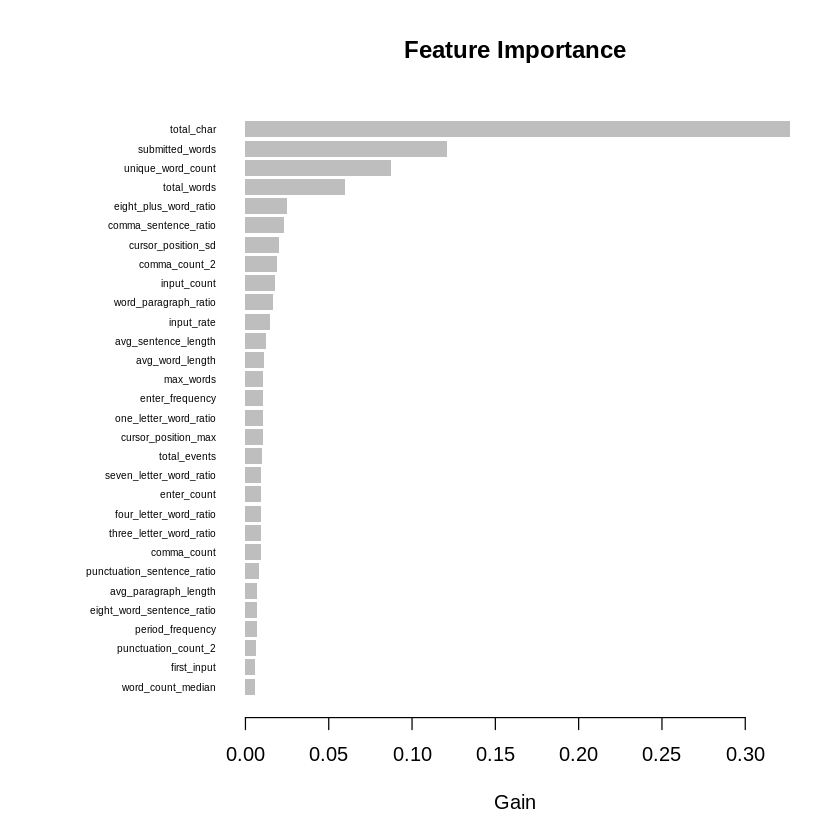

In [11]:
# Convert data to lightgbm dataset format
train_data <- lightgbm::lgb.Dataset(data = as.matrix(train_scores[, !(names(train_scores) %in% c("score", "id", "essay"))]), label = train_scores$score)

# Set up LGBM parameters
train_params <- list(
    objective = "regression",
    metric = "rmse",
    boosting_type = "gbdt",
    num_leaves = 14,
    learning_rate = 0.05,
    feature_fraction = 0.83,
    nthread = 6
)

# Cross-Validation
set.seed(123)
cv_results <- lightgbm::lgb.cv(
    params = train_params,
    data = train_data,
    nrounds = 250,
    stratified = TRUE,
    nfold = 8
)
print(cv_results)

# Train LGBM Model
classifier_LGBM <- lightgbm::lgb.train(
    params = train_params,
    data = train_data,
    nrounds = cv_results$best_iter
)

# Plot feature importance
importance <- lgb.importance(classifier_LGBM, percentage = TRUE)
print(importance[1:30])
lgb.plot.importance(importance, top_n = 30, measure = "Gain")
cor(as.matrix(train_scores[, c("score", importance$Feature[1:30])]))

# FEATURE SELECTION

In [13]:
top_features <- as.matrix(train_scores[, importance$Feature[1:30]])
top_features_df <- lightgbm::lgb.Dataset(data = top_features, label = train_scores$score)

# Cross-Validation with top features only
set.seed(123)
cv_results <- lightgbm::lgb.cv(
    params = train_params,
    data = top_features_df,
    nrounds = 250,
    stratified = TRUE,
    nfold = 10
)
print(cv_results)

# Re-train on top features only
classifier_LGBM <- lightgbm::lgb.train(
    params = train_params,
    data = top_features_df,
    nrounds = cv_results$best_iter
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6509
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6509
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6509
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 30
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true

# PREPPING THE TEST SET

In [14]:
test_logs <- data_cleaning(test_logs)
test_scores <- get_essay(test_logs, test_scores)
test_scores <- create_essay_features(test_scores)
test_scores <- create_features(test_logs, test_scores)

cat("\n", "\n", "TRAIN_SCORES VARIABLES:", "\n")
print(names(train_scores))

cat("\n", "\n", "TEST_SCORES VARIABLES:", "\n")
print(names(test_scores))

print(classifier_LGBM)

test_scores[test_scores == "NaN"] <- 0
test_scores[test_scores == "Inf"] <- 0
test_scores[is.na(test_scores)] <- 0

Error reformatting MOVE activities:
 subscript out of bounds 
 Factor w/ 1 level "Input": 1 1 1 1 1 1

 
 INVALID VALUES: < table of extent 0 >

 
 INVALID TEXT_CHANGE VALUES: < table of extent 0 >

 RARE VALUES: [1] "q"     "Space"

 REMAINING VALUES: [1] "RareKey"
Total 'Event' Values:  1 Factor w/ 1 level "RareKey": 1 1 1 1 1 1

 VALID TEXT_CHANGE VALUES: [1] " " "q"
[1] "Total Number of Essays with Errors:  3"

 
 TRAIN_SCORES VARIABLES: 
 [1] "id"                           "cursor_position_max"         
 [3] "cursor_position_kurt"         "cursor_position_skew"        
 [5] "cursor_position_IQR"          "cursor_position_median"      
 [7] "cursor_position_sd"           "cursor_position_mean"        
 [9] "first_input"                  "submission_time"             
[11] "word_count_kurt"              "word_count_skew"             
[13] "word_count_IQR"               "word_count_median"           
[15] "word_count_sd"                "word_count_mean"             
[17] "max_words" 

# MAKE PREDICTIONS

In [15]:
# test_predictions <- predict(classifier_LGBM, as.matrix(test_scores[, names(test_scores) != "id" & names(test_scores) != "essay"]))
test_predictions <- predict(classifier_LGBM, as.matrix(test_scores[, importance$Feature[1:30]]))
sample_submission <- data.frame(id = test_scores$id, score = test_predictions)

write_csv(sample_submission, "submission.csv")